## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Make sure to change path if you put the zip elsewhere
!unzip drive/MyDrive/chest_xray.zip

## Create dataset from directory

In [16]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


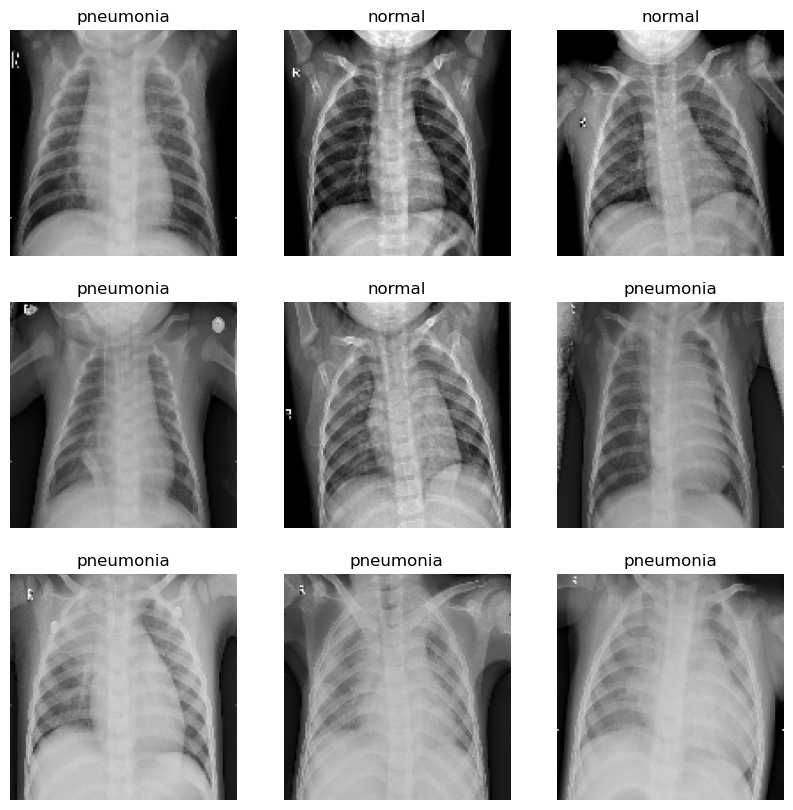

2024-05-10 15:00:42.552318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


AttributeError: '_PrefetchDataset' object has no attribute 'shape'

In [26]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [18]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2024-05-10 14:16:11.722385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

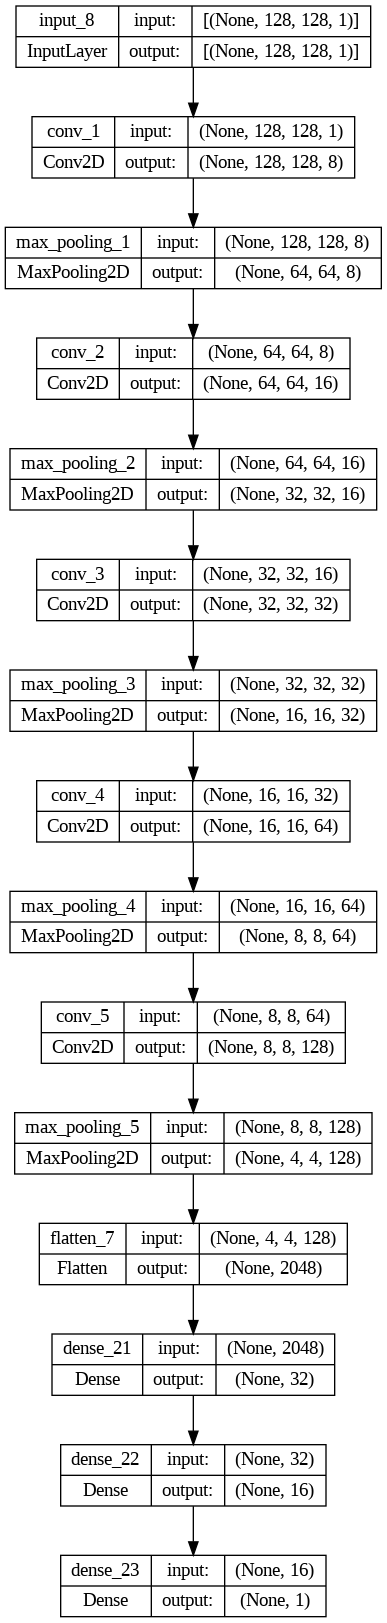

In [19]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.
conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
max_pooling_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_1')(conv_1)

conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_2')(conv_2)

conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_pooling_2)    
max_pooling_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_3')(conv_3)

conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_pooling_3)    
max_pooling_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_4')(conv_4)

conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_pooling_4)    
max_pooling_5 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_5')(conv_5)

flatten_7 = Flatten(name='flatten_7')(max_pooling_5)


dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)


cnn_output = layers.Dense(1, activation='sigmoid')(dense_22)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [6]:
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

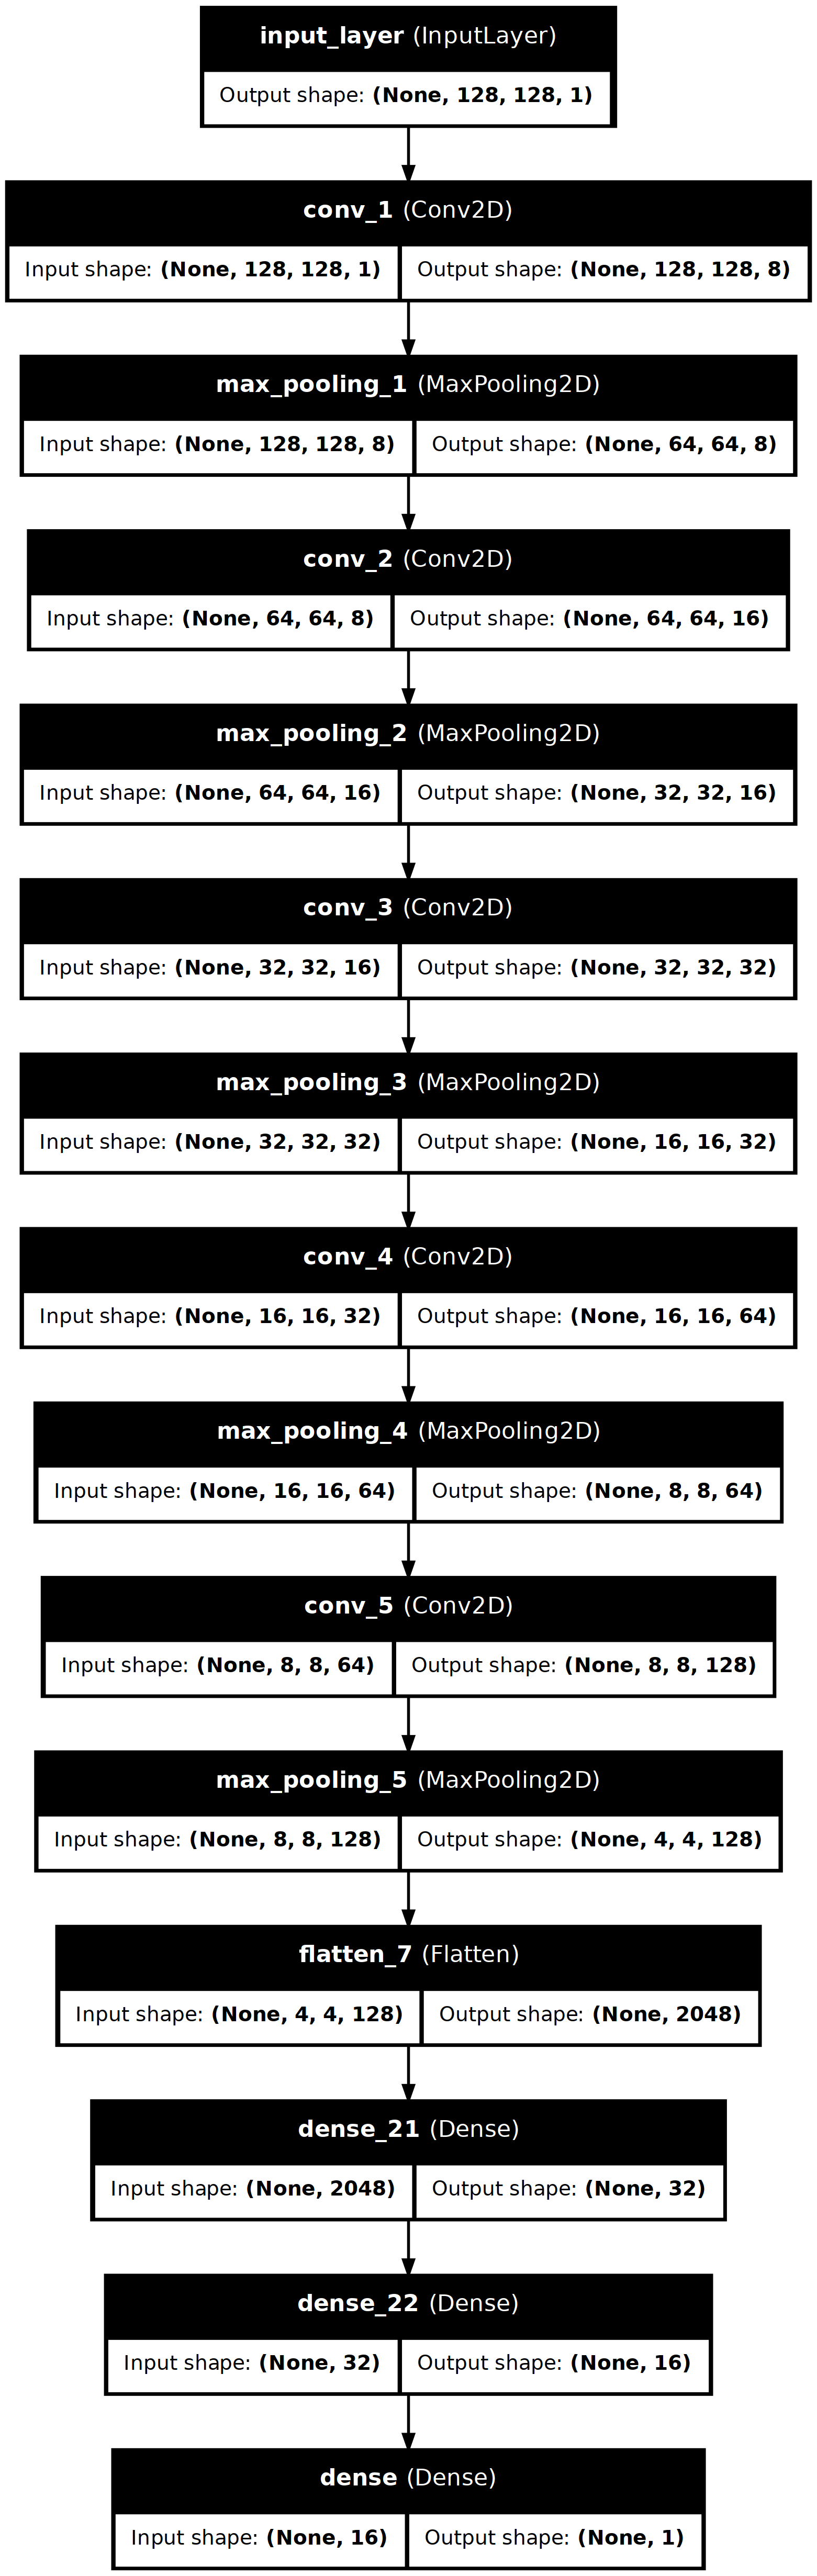

In [7]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [20]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5


82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.3914 - loss: 2.1091 - val_accuracy: 0.5000 - val_loss: 0.6526
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.6847 - loss: 0.4546 - val_accuracy: 0.8125 - val_loss: 0.2681
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.9450 - loss: 0.1396 - val_accuracy: 0.8750 - val_loss: 0.3210
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.9613 - loss: 0.0931 - val_accuracy: 0.8750 - val_loss: 0.1963
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.9548 - loss: 0.1188 - val_accuracy: 1.0000 - val_loss: 0.0948


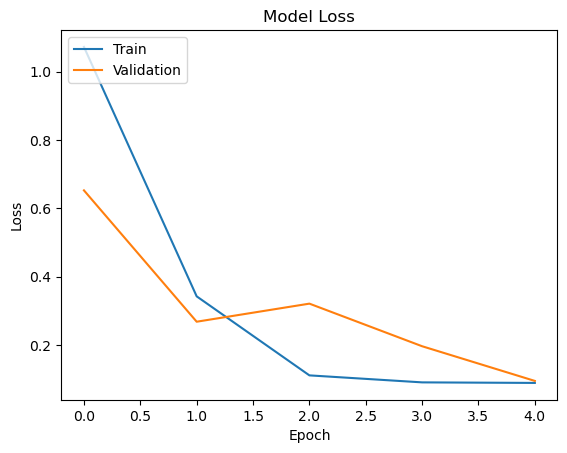

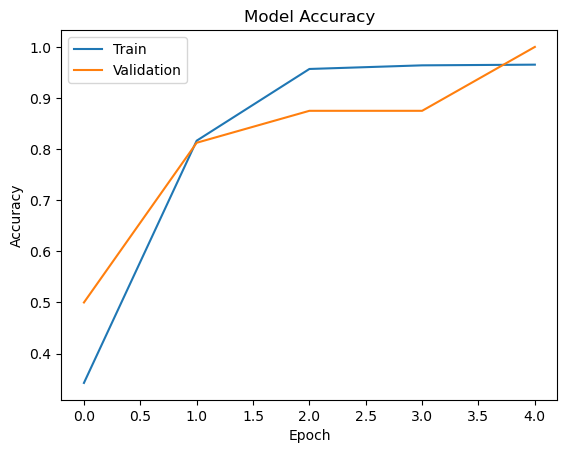

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-05-10 14:17:56.013561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


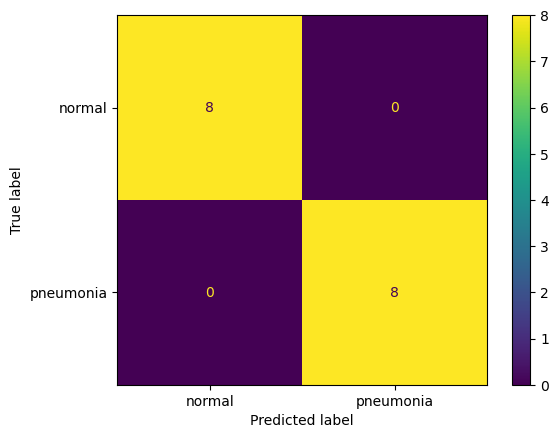

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set
from sklearn.metrics import confusion_matrix

val_prediction = cnn.predict(val_images).squeeze().round().astype(int)

cm = confusion_matrix(val_labels, val_prediction)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
disp.plot()
plt.show()

In [23]:
from sklearn.metrics import f1_score, accuracy_score
print("f1 score :", f1_score(val_labels, val_prediction))
print("accuracy :", accuracy_score(val_labels, val_prediction))

f1 score : 1.0
accuracy : 1.0


 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

2024-05-10 14:18:08.536060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


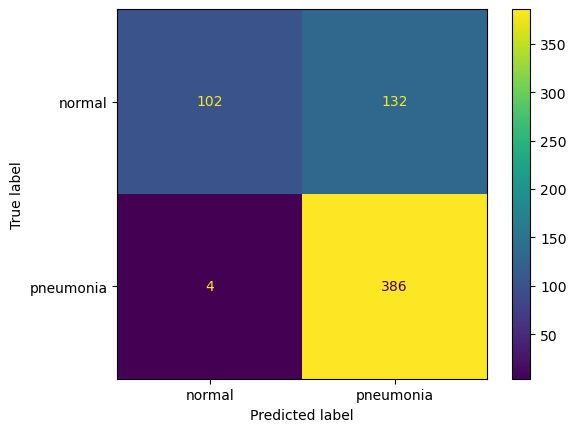

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in test_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set
from sklearn.metrics import confusion_matrix

val_prediction = cnn.predict(val_images).squeeze().round().astype(int)

cm = confusion_matrix(val_labels, val_prediction)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
disp.plot()
plt.show()

In [25]:
from sklearn.metrics import f1_score, accuracy_score
print("f1 score :", f1_score(val_labels, val_prediction))
print("accuracy :", accuracy_score(val_labels, val_prediction))

f1 score : 0.8502202643171805
accuracy : 0.782051282051282
